# Lending Club Data - Inferential Statistics

The question that this project seeks to answer is whether macroeconomic factors at the time that a loan is originated have a measurable impact on the likelihood that borrowers will default. To analyze this, linear regressions will be performed comparing the three macroeconomic variables of interest - monthly national bankruptcy filings, unemployment rate, and change in the S&P 500 stock index - to the outcome variable of interest, the proportion of loans that are eventually charged off.

First, the necessary libraries are imported. Also, the dataset to be used is imported from a .pkl file, which is available in the following shared Google Drive location:

https://drive.google.com/open?id=1N0Zn0UldZaF4Dxs8bmRBr72TeBzP8dVl

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_pickle(r'..\data\stat_data.pkl')

Linear regression is used to evaluate the impact of each outcome variable of interest on the default rate. Bootstrapping is used to determine whether the observed relationships are stastistically significant.

First, a linear regression bootstrapping function is declared.

In [2]:
# Declare bootstrap function
def bootstrap_linreg(x, y, size=10000):
    """Takes in an array of x and an array of y, which are paired data, and a size as parameters. Performs linear regressions
    on the paried data and returns an array of slopes and an array of intercepts with length equal to the size parameter"""
    
    # Convert x and y to numpy arrays for use below
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Set up the index array, as well as an array for the slope and interept replicates
    ind = np.arange(len(x))
    slope_reps = np.empty(size)
    intercept_reps = np.empty(size)

    # Generate replicates by running a linear regression on each generated set of pairs.
    for i in range(size):
        test_ind = np.random.choice(ind, size=len(ind))
        test_x, test_y = x[test_ind], y[test_ind]
        slope_reps[i], intercept_reps[i] = np.polyfit(test_x, test_y, 1)

    return slope_reps, intercept_reps

Next, a small amount of data cleanup and re-scaling is performed. Monthly bankruptcies are not in a numeric format, so they are converted. Also, monthly bankruptcies are of a large scale (tens of thousands per month), so they are re-scaled to "thousands of monthly bankruptcies."

In [3]:
# Convert BKs to numeric
df['monthly_bks'] = pd.to_numeric(df['monthly_bks'], errors='coerce')

# Convert BKs to 1,000s
df['monthly_bks'] = df['monthly_bks']/1000

The unemployment rate, number of monthly bankruptcies, and monthly change in the S&P 500 are the variables of interest that will be tested. Loans are broken out into 36- and 60- month loan terms, and into grades A through F (a grade G exists, but there are very few grade-G loans). To test each variable for each subgroup, a list that contains a tuple for each specification - e.g., ('unemployment_rate', '36 months', 'A') - is created.

In [4]:
columns = ('unemployment_rate', 'monthly_bks', 'sp_500_diff')
terms = ('36 months', '60 months')
grades = ('A', 'B', 'C', 'D', 'E', 'F')

# Generate list of specifications to test, equal to the cartesian product of the 3 lists above
specifications = [(a, b, c) for a in columns for b in terms for c in grades]

Next, each of the specifications generated above is looped through. For each specification, 10,000 bootstrap replicates are generated and the slope, intercept, and sample size is saved in a dictionary containing the test results.

In [5]:
tests = {}
for c, t, g in specifications:
    subset = df[(df.grade == g) & (df.term == t)]
    slope, intercept = bootstrap_linreg(subset[c], subset['charge_off_flag'])
    tests[(c, t, g)] = (slope, intercept, len(subset))

## Results

Each bootstrap replicate generated a slope and intercept term. The slope term is the outcome of interest, as it represents the impact ondefault rates. The 95% confidence intervals of each calculated slope, along with the sample size, are printed below. All significant results are in bold.

The large majority of results are not statistically significant. Of those that are significant, all results that correlate the unemployment rate with charge-off rates have the <i>opposite</i> sign than expected - a lower unemployment rate at the time of origination is correlated with a higher default likelihood. Similarly for the bankruptcy rate - lower monthly national bankruptcies at origination are associated with higher default rates.

There are two significant results correlating the monthly change in the S&P 500 with default rates, but one term is positive and the other negative, suggesting low generalizability of any results.

In [6]:
for key, value in tests.items():
    percentile_range = np.percentile(value[0], [2.5, 97.5])
    if percentile_range[0] > 0 or percentile_range[1] < 0:
        print('variable: {}   term: {}   grade: {}\nslope CI: \033[1m{}\033[0m   (n={})'.format(key[0], key[1], key[2],
                                                                                                percentile_range, value[2]))
    else:
        print('variable: {}   term: {}   grade: {}\nslope CI: {}   (n={})'.format(key[0], key[1], key[2],
                                                                                  percentile_range, value[2]))

variable: unemployment_rate   term: 36 months   grade: A
slope CI: [-0.00135949  0.001641  ]   (n=60795)
variable: unemployment_rate   term: 36 months   grade: B
slope CI: [-0.00468227 -0.00099431]   (n=90624)
variable: unemployment_rate   term: 36 months   grade: C
slope CI: [-0.01494143 -0.00967629]   (n=68178)
variable: unemployment_rate   term: 36 months   grade: D
slope CI: [-0.02550619 -0.01771471]   (n=34891)
variable: unemployment_rate   term: 36 months   grade: E
slope CI: [-0.04220207 -0.02550099]   (n=9765)
variable: unemployment_rate   term: 36 months   grade: F
slope CI: [-0.07110762 -0.02906948]   (n=2113)
variable: unemployment_rate   term: 60 months   grade: A
slope CI: [-0.02670311  0.02487238]   (n=624)
variable: unemployment_rate   term: 60 months   grade: B
slope CI: [-0.00647652  0.02579703]   (n=4049)
variable: unemployment_rate   term: 60 months   grade: C
slope CI: [-0.00800087  0.02261887]   (n=6081)
variable: unemployment_rate   term: 60 months   grade: D
slop

To visualize a salient subset of the results, a histogram of all replicates for 36-month loans using the unemployment rate as the independent variable is shown below.

The first graph, showing grade A loans, reveals a distribution that is almost perfectly centered around zero, underscoring that there is no significance for that subset of loans. Grades B through F, in contrast, show mean slopes well below zero. 

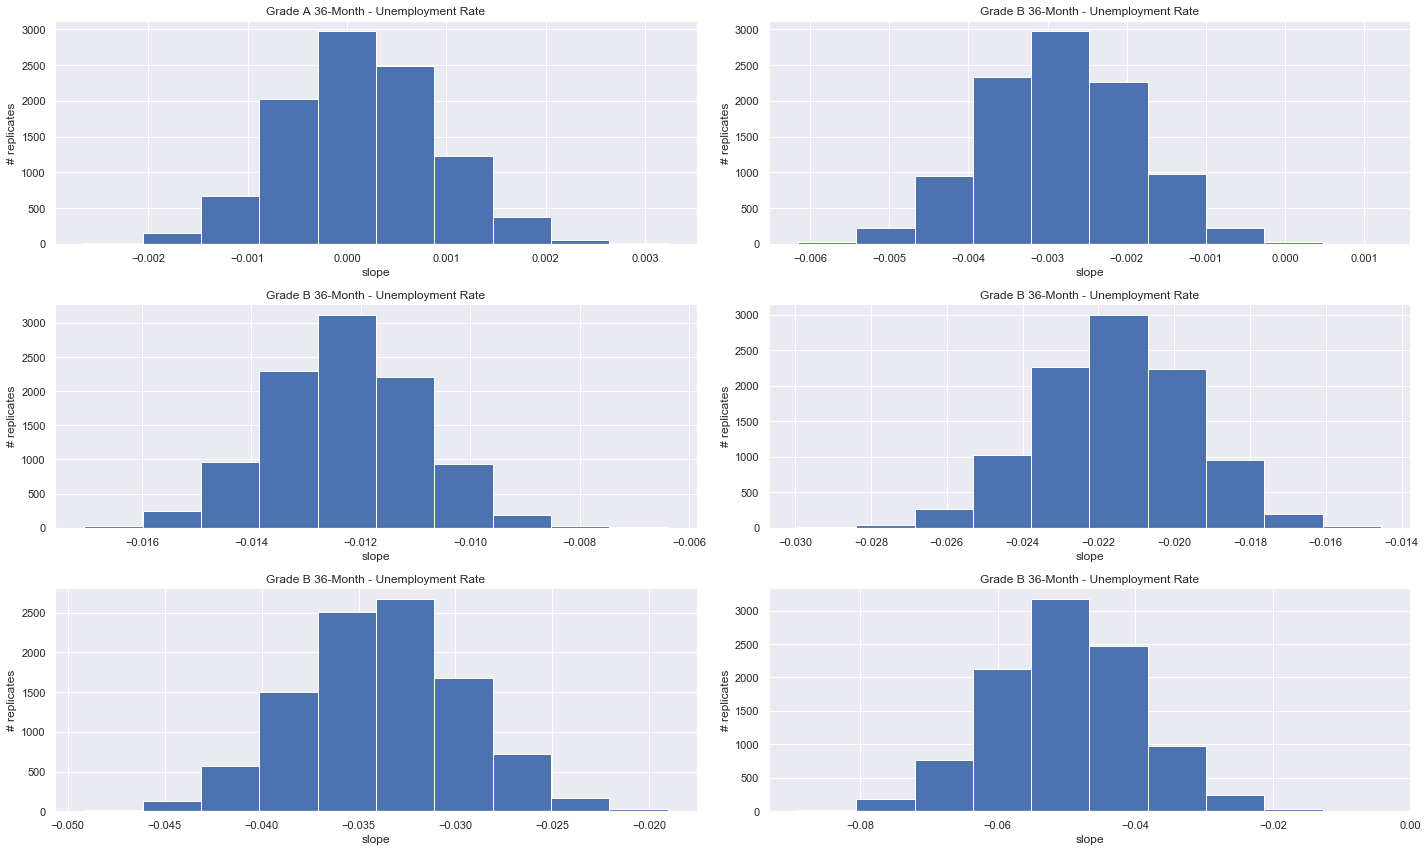

In [7]:
sns.set()

fig, ax = plt.subplots(figsize=(20, 12))
plt.subplot(3, 2, 1)
_ = plt.hist(tests['unemployment_rate', '36 months', 'A'][0])
_ = plt.title('Grade A 36-Month - Unemployment Rate')
_ = plt.xlabel('slope')
_ = plt.ylabel('# replicates')

plt.subplot(3, 2, 2)
_ = plt.hist(tests['unemployment_rate', '36 months', 'B'][0])
_ = plt.title('Grade B 36-Month - Unemployment Rate')
_ = plt.xlabel('slope')
_ = plt.ylabel('# replicates')

plt.subplot(3, 2, 3)
_ = plt.hist(tests['unemployment_rate', '36 months', 'C'][0])
_ = plt.title('Grade B 36-Month - Unemployment Rate')
_ = plt.xlabel('slope')
_ = plt.ylabel('# replicates')

plt.subplot(3, 2, 4)
_ = plt.hist(tests['unemployment_rate', '36 months', 'D'][0])
_ = plt.title('Grade B 36-Month - Unemployment Rate')
_ = plt.xlabel('slope')
_ = plt.ylabel('# replicates')

plt.subplot(3, 2, 5)
_ = plt.hist(tests['unemployment_rate', '36 months', 'E'][0])
_ = plt.title('Grade B 36-Month - Unemployment Rate')
_ = plt.xlabel('slope')
_ = plt.ylabel('# replicates')

plt.subplot(3, 2, 6)
_ = plt.hist(tests['unemployment_rate', '36 months', 'F'][0])
_ = plt.title('Grade B 36-Month - Unemployment Rate')
_ = plt.xlabel('slope')
_ = plt.ylabel('# replicates')

plt.tight_layout()
plt.show()

## Discussion

As mentioned, the signs on nearly all statistically significant coefficients are the opposite of what was hypothesized. There may be a variety of reasons that this may be the case, including:

### Improving Economic Conditions

Both the unemployment rate and the monthly bankruptcy rates have decreased significantly in the time period analyzed (2010 to 2015). It is possible that what matters for loan default rates is the <i>improvement</i> in economic conditions rather than their absolute state. As high unemployment and bankruptcy rates for the time period analyzed are followed by rapid decreases in their respective rates, poor economic conditions may predict lower default rates.

If this is the cause of the observed results, then evaluation of loan performance over larger periods would be required, as larger periods would include more macroeconomic fluctuations - the period evaluated is characterized by constant and relatively rapid macroeconomic improvement, which is not generally expected.

### Independent Variable Selection

If changes in economic conditions are more important than baseline economic conditions, then it is possible that independent variables with low explanatory power were used for this analysis. For example, using the <i>change in the unemployment rate</i> over the prior 12 months as the independent variable may be more informative than using the point-in-time unemployment rate at the time of origination.

It is also possible that there are macroeconomic variables that impact loan default rates that were not analyzed, including average wages or GDP per capita, stock indices other than the S&P 500, or other proxies for macroeconomic performance.

### Lending Club Risk Modeling

It could be that Lending Club already accounts for macroeconomic factors in their loan originations and reject borrowers with high risk profiles when the economy is doing poorly. If Lending Club does so, and overestimated the impact of macroeconomic factors on borrower default probability, then the observed results are expected.